# Geographically Weighted Regression (GWR): A Hands-on Urban Heat Island Example

**Context (GEOG 475: Advanced GIS)**  
In many urban environmental problems, relationships vary across space. A single global regression model may hide local patterns.

## What we will do today (workflow)
1. Simulate a city-like dataset (points + urban variables)
2. Fit a global regression model (OLS)
3. Diagnose spatial patterns in residuals (Moran’s I)
4. Fit a local regression model (GWR) with bandwidth selection
5. Visualize local coefficients and compare OLS vs GWR

**Key concept:** spatial non-stationarity (spatially varying relationships)

In [1]:
# Install packages (Colab)
!pip -q install numpy pandas matplotlib scipy statsmodels
!pip -q install libpysal esda
!pip -q install mgwr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
import statsmodels.api as sm

from libpysal.weights import KNN
from esda.moran import Moran

from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

np.random.seed(42)

## Step 1 — Create sampling locations (a simplified “city”)

We simulate point locations in a 2D plane:
- A denser cluster near the city center (CBD)
- A sparser ring of points in the outer area

This is more realistic than a uniform grid because real sampling / urban features are not evenly distributed.

In [2]:
# Generate coordinates for a city-like sampling pattern
# - Center cluster: Gaussian around (0,0)
# - Outer ring: points around a ring with noise

N_center = 220
N_outer  = 120

xy_center = np.random.normal(loc=0.0, scale=1.2, size=(N_center, 2))

angles = np.random.uniform(0, 2*np.pi, N_outer)
r = np.random.uniform(2.0, 5.0, N_outer) + np.random.normal(0, 0.3, N_outer)
xy_outer = np.c_[r*np.cos(angles), r*np.sin(angles)]

coords = np.vstack([xy_center, xy_outer])
x, y = coords[:, 0], coords[:, 1]

# Distance to CBD (0,0)
dist_cbd = np.sqrt(x**2 + y**2)
dist_cbd_z = (dist_cbd - dist_cbd.mean()) / dist_cbd.std()

print("Number of points:", len(coords))

Number of points: 340


## Step 2 — Create explanatory variables (urban predictors)

We simulate typical predictors used in urban heat island studies:

- **NDVI**: greener areas tend to be cooler
- **Building density**: dense built-up areas tend to be hotter
- **Distance to CBD**: captures an urban–suburban gradient
- **Impervious surface (optional)**: often correlated with building density (useful to discuss collinearity)

These variables are synthetic, but the structure is realistic.

In [3]:
# NDVI: higher in outer areas, lower near CBD (with noise)
ndvi = 0.2 + 0.12 * dist_cbd + np.random.normal(0, 0.08, size=len(dist_cbd))
ndvi = np.clip(ndvi, 0, 1)

# Building density: higher near CBD, lower in outer areas (with noise)
building_density = 1 / (1 + np.exp((dist_cbd - 2.0))) + np.random.normal(0, 0.06, size=len(dist_cbd))
building_density = np.clip(building_density, 0, 1)

# Impervious surface: correlated with building density and inversely with NDVI (optional variable)
impervious = 0.7 * building_density + 0.2 * (1 - ndvi) + np.random.normal(0, 0.05, size=len(dist_cbd))
impervious = np.clip(impervious, 0, 1)

## Step 3 — Generate the response (LST) with spatial non-stationarity

To demonstrate why OLS can fail, we **intentionally** create a process where regression coefficients vary across space:

- **Mechanism A (NDVI effect varies with distance):**
  NDVI cools more strongly near the CBD than in outer areas.

- **Mechanism B (Building effect varies by direction):**
  Building density has a stronger warming effect on the east side (x > 0).

- **Mechanism C (Spatially structured error):**
  We add a smooth spatial random field so that OLS residuals show spatial clustering.

This ensures the example is stable and pedagogically useful:
**OLS will be misspecified**, and **GWR will reveal local patterns**.

In [4]:
# Spatially varying coefficient for NDVI:
# - Stronger cooling near CBD (more negative), weaker cooling in outer areas
# Example range: -7 (center) to -2 (outer)
beta_ndvi = -7 + 5 * (dist_cbd / dist_cbd.max())

# Spatially varying coefficient for building density:
# - Stronger warming on the east side (x > 0)
# Example range: ~3 (west) to ~6 (east)
beta_bld = 4.5 + 1.5 * np.tanh(x / 1.5)

# Global effect for distance-to-CBD (often CBD hotter, so farther = cooler)
beta_dist = -0.8

# Base temperature (intercept)
beta0 = 33.0

# Add a smooth spatial random field (RBF kernel) to create spatially structured errors
D = cdist(coords, coords)
length_scale = 1.2
K = np.exp(-(D**2) / (2 * length_scale**2))
K = K + 1e-6 * np.eye(len(coords))

L = np.linalg.cholesky(K)
spatial_field = L @ np.random.normal(0, 1, size=len(coords))
spatial_field = (spatial_field - spatial_field.mean()) / spatial_field.std()

# Observation noise
noise = np.random.normal(0, 0.8, size=len(coords))

# Generate LST (Land Surface Temperature)
lst = (
    beta0
    + beta_ndvi * ndvi
    + beta_bld * building_density
    + beta_dist * dist_cbd_z
    + 1.2 * spatial_field
    + noise
)

## Step 4 — Visualize spatial patterns

Before modeling, we visualize:
- LST spatial distribution
- NDVI and building density patterns

This provides intuition about why spatial processes may not follow a single global rule.

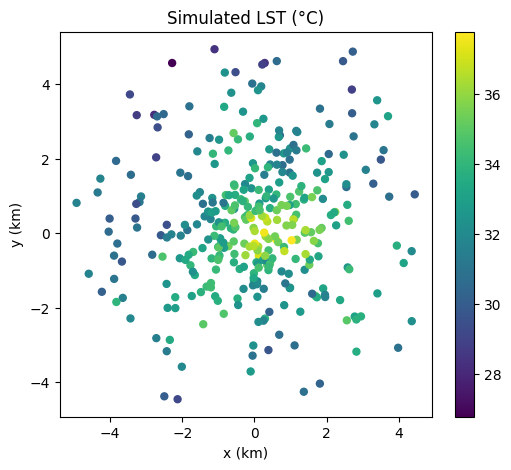

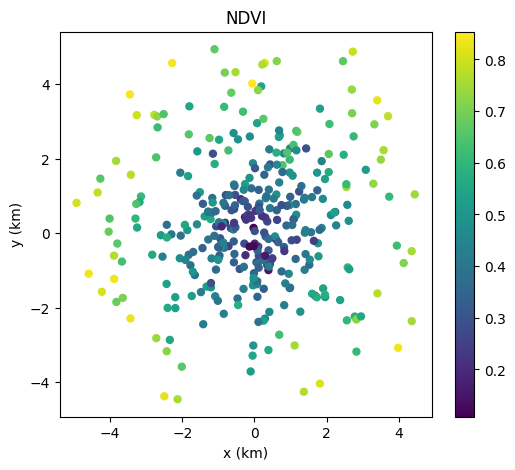

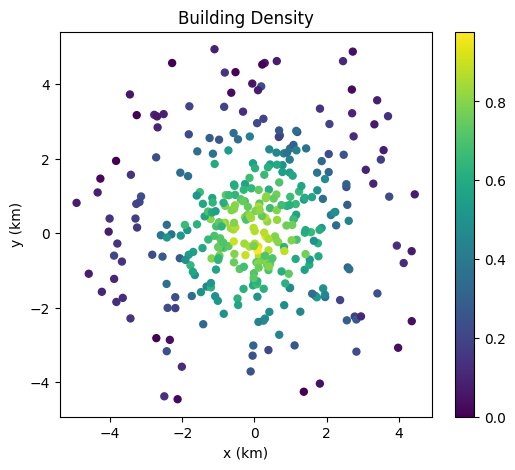

In [5]:
def scatter_map(values, title):
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, c=values, s=25)
    plt.colorbar()
    plt.title(title)
    plt.xlabel("x (km)")
    plt.ylabel("y (km)")
    plt.show()

scatter_map(lst, "Simulated LST (°C)")
scatter_map(ndvi, "NDVI")
scatter_map(building_density, "Building Density")

## Step 5 — Fit a global regression model (OLS)

We start with an Ordinary Least Squares regression:

\[
LST = \alpha + \beta_1 NDVI + \beta_2 BuildingDensity + \beta_3 DistCBD + \epsilon
\]

**OLS assumption:** coefficients are constant everywhere (global stationarity).

We expect OLS to produce “reasonable average” effects, but it cannot capture the spatially varying relationships we built into the data.

In [6]:
df = pd.DataFrame({
    "x": x, "y": y,
    "lst": lst,
    "ndvi": ndvi,
    "building_density": building_density,
    "dist_cbd_z": dist_cbd_z
})

X = df[["ndvi", "building_density", "dist_cbd_z"]].values
X = sm.add_constant(X)
y_ = df["lst"].values

ols = sm.OLS(y_, X).fit()
print(ols.summary())

df["ols_pred"] = ols.predict(X)
df["ols_resid"] = df["lst"] - df["ols_pred"]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     139.9
Date:                Thu, 05 Feb 2026   Prob (F-statistic):           7.75e-59
Time:                        17:41:43   Log-Likelihood:                -569.11
No. Observations:                 340   AIC:                             1146.
Df Residuals:                     336   BIC:                             1162.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.2414      0.640     53.530      0.0

## Step 6 — Diagnose OLS residuals (spatial patterns)

If a model is missing a spatial process, residuals often show spatial structure.

We will:
1. Map the OLS residuals
2. Test residual spatial autocorrelation with **Moran’s I**

**Interpretation:**
- Significant Moran’s I suggests residuals are spatially clustered,
  indicating the global model is likely misspecified for a spatial process.

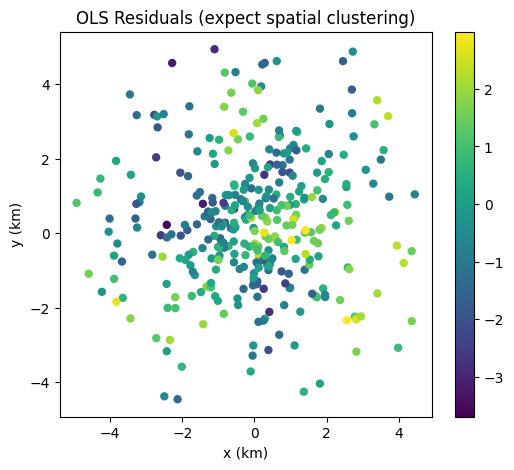

Moran's I (OLS residuals): I=0.477, p=0.0010


In [7]:
scatter_map(df["ols_resid"].values, "OLS Residuals (expect spatial clustering)")

# Build a K-nearest neighbor weights matrix for Moran's I
w = KNN.from_array(coords, k=8)
w.transform = "R"

mi_ols = Moran(df["ols_resid"].values, w, permutations=999)
print(f"Moran's I (OLS residuals): I={mi_ols.I:.3f}, p={mi_ols.p_sim:.4f}")

## Step 7 — Fit a local regression model (GWR)

GWR estimates a separate set of regression coefficients for each location using nearby observations:

\[
LST_i = \beta_0(u_i,v_i) + \sum_k \beta_k(u_i,v_i) X_{ik} + \epsilon_i
\]

Key components:
- **Kernel**: nearby observations get higher weights
- **Bandwidth**: controls how “local” the model is
  - small bandwidth → very local (risk of overfitting)
  - large bandwidth → closer to global model

We use AICc-based bandwidth selection (a common default in practice).

In [8]:
# mgwr expects y as (n,1), X without an explicit constant (it handles intercept internally)
y_gwr = df["lst"].values.reshape(-1, 1)
X_gwr = df[["ndvi", "building_density", "dist_cbd_z"]].values

# Bandwidth selection (AICc)
selector = Sel_BW(coords, y_gwr, X_gwr)
bw = selector.search(bw_min=20)
print("Selected bandwidth:", bw)

# Fit GWR
gwr_model = GWR(coords, y_gwr, X_gwr, bw)
gwr_results = gwr_model.fit()
print(gwr_results.summary())

Selected bandwidth: 50.0
Model type                                                         Gaussian
Number of observations:                                                 340
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            566.094
Log-likelihood:                                                    -569.108
AIC:                                                               1146.215
AICc:                                                              1148.395
BIC:                                                              -1392.431
R2:                                                                   0.555
Adj. R2:                                                              0.551

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---

## Step 8 — Visualize local coefficients and local fit (local R²)

GWR outputs:
- **Local coefficients** for each predictor at each location
- **Local R²** (how well the model fits locally)

We expect:
- NDVI coefficient more negative near CBD (stronger cooling)
- Building density coefficient stronger on the east side (x > 0)

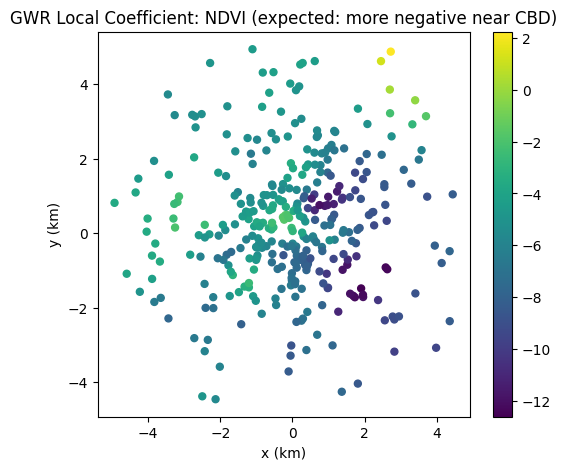

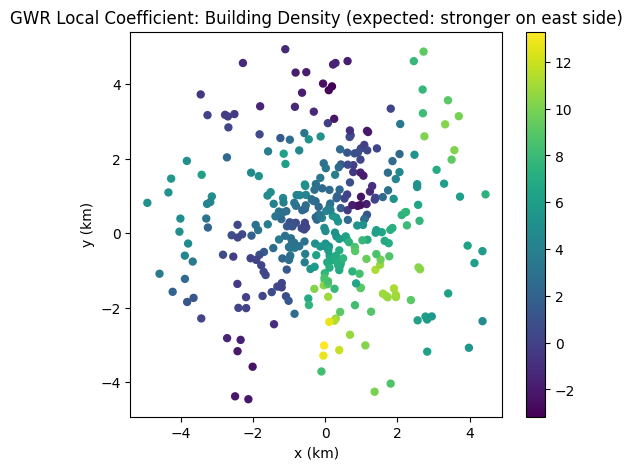

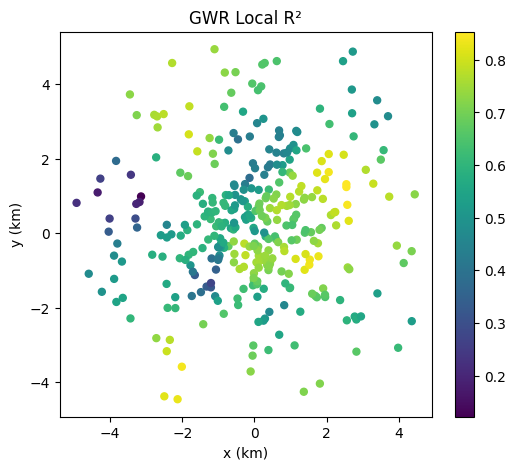

In [9]:
params = gwr_results.params  # columns: intercept + betas
local_b0   = params[:, 0]
local_ndvi = params[:, 1]
local_bld  = params[:, 2]
local_dist = params[:, 3]

scatter_map(local_ndvi, "GWR Local Coefficient: NDVI (expected: more negative near CBD)")
scatter_map(local_bld,  "GWR Local Coefficient: Building Density (expected: stronger on east side)")
scatter_map(gwr_results.localR2, "GWR Local R²")

## Step 9 — Compare residuals: OLS vs GWR

A good sign (not a guarantee) is that GWR reduces spatial clustering in residuals.

We will:
- Map GWR residuals
- Compute Moran’s I for GWR residuals

**Expected outcome:**
- Moran’s I should decrease (and may become non-significant),
  indicating the local model captures more spatial structure than OLS.

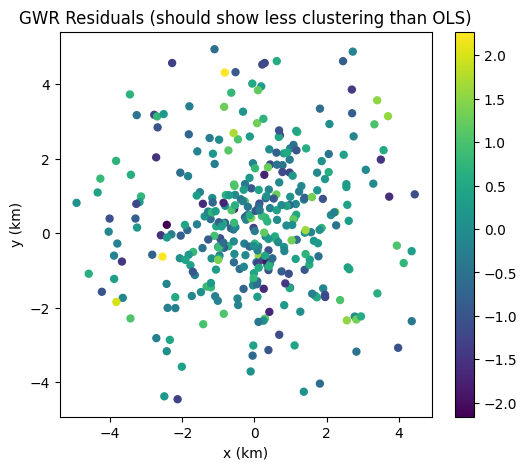

Moran's I (GWR residuals): I=-0.002, p=0.4870


In [10]:
df["gwr_pred"] = gwr_results.predy.flatten()
df["gwr_resid"] = df["lst"].values - df["gwr_pred"].values

scatter_map(df["gwr_resid"].values, "GWR Residuals (should show less clustering than OLS)")

mi_gwr = Moran(df["gwr_resid"].values, w, permutations=999)
print(f"Moran's I (GWR residuals): I={mi_gwr.I:.3f}, p={mi_gwr.p_sim:.4f}")

## Step 10 — Discussion: When is GWR appropriate?

**GWR is useful when:**
- You expect spatially varying relationships (spatial non-stationarity)
- You want interpretability at a local scale (mapping coefficients)
- Diagnostics suggest a global model misses spatial structure

**GWR limitations / cautions:**
- Can overfit if bandwidth is too small
- Local multicollinearity can make coefficients unstable
- GWR is descriptive; it does not automatically provide causal inference

**Takeaway:**  
OLS provides a global “average relationship.”  
GWR helps reveal how relationships vary across space.